In [22]:
%matplotlib notebook
from quantum_builder import QuantumBuilder
import logging
import matplotlib.pyplot as plt

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}

# Fitting of anticrossing
First we evalaute the transition energies of the cqps system
\begin{equation}
\mathcal{H} = E_L(\hat{n} - f)^2 - \frac{E_s}{2}\left[\left|n+1\right\rangle{\left\langle{n}\right|} + \left|n\right\rangle{\left\langle{n+1}\right|}\right],
\end{equation}

Because it is so similar to the transmon Hamiltonian
\begin{equation}
      \begin{aligned}\label{eq:transmon-hamiltonian}
        &\mathcal{H} = E_C{\left(\hat{N}-N_\text{ext}\right)^2}- \tilde{E}_J\cos\left(\hat{\varphi}\right)\\
        & \begin{cases}
          E_{C} & = \frac{(2e)^{2}}{2C_{\Sigma}}\\
          C_{\Sigma} & = 2C_{J0} + C_{s}\\
          \tilde{E}_{J}              &              =             E_{J0}              \times
          2\left|\cos\left(\frac{\pi\Phi_\text{ext}}{\Phi_0}\right)\right|,
        \end{cases}
      \end{aligned}
    \end{equation}
    
I will simply use the transmon Hamitlonian to evaluate energies

In [43]:
SIMULATION_PARAMETERS = {
    "number_of_states": 13,
    "number_of_levels_to_simulate": 2
}
QUBIT_PARAMETERS = {
    "ES": 10,
    "inductive_loop_squares": 30, # 30 140x140nm squares
     **SIMULATION_PARAMETERS
}

cqps_qubit = QuantumBuilder.build_cqps_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)

cqps_qubit_constant_manager:68:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

Energies
EL:                                               72.05 (GHz)
ES:                                               10.00 (GHz)

Raw Parameters
number_of_states:                                 13
inductive_loop_squares:                           30.00 (100x100nm²)

Derived Parameters
inductance:                                       45.00 (nH)




cqps_qubit_constant_manager:57:override_parameters
⮑  Overriding to the following values:
EL:       13
ES:       6.4


cqps_qubit_simulator:55:simulate
⮑  💻 Running simulation

cqps_qubit_simulator:96:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


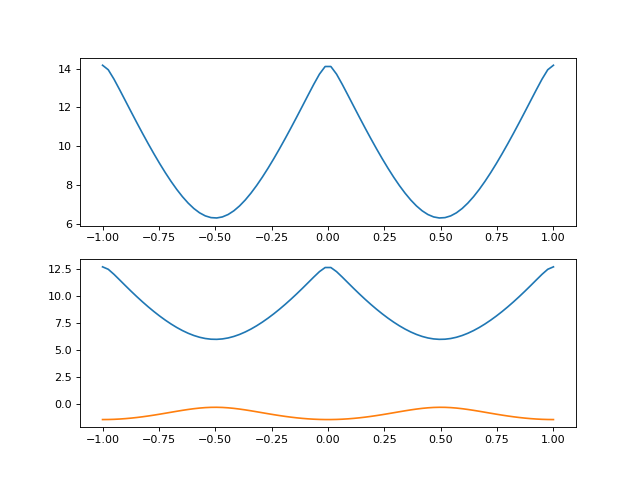

In [44]:
FLUX_NUMBER = np.linspace(-1, 1, 80)
EL = 13
ES = 6.4
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)

simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
transition01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
simulation_graph, = ax[0].plot(FLUX_NUMBER, transition01)

ax[1].plot(FLUX_NUMBER, simulation["eigvals"][:, 1])
ax[1].plot(FLUX_NUMBER, simulation["eigvals"][:, 0])

## Next we inroduce interaction with the resonator
*Hamitlonian at this stage*

\begin{equation}
 \frac{1}{\hbar}H_{qubit-resonator} = \frac{\omega_{q}}{2}\sigma_z + \omega_r{a^{\dagger}}a + g(a^{\dagger} + a)\sigma_x
\end{equation}

In the truncated matrix form between states $\left|e, N\right\rangle$ and $\left|g, N+1\right\rangle$
\begin{equation}
  \mathcal{H}_{middle} = \begin{pmatrix}
    \frac{\omega_q}{2} + (N)\omega_r & g\sqrt{N+1}\\
    g\sqrt{N+1} & -\frac{\omega_q}{2} + (N+1)\omega_r
  \end{pmatrix}
\end{equation}

We introduce the detuning factor $\delta =\omega_{q} - \omega_{r}$ in order to write out

\begin{equation}
  \mathcal{H}_{middle} = \begin{pmatrix}
    \frac{\delta}{2} + (N+\frac{1}{2})\omega_r & g\sqrt{N+1}\\
    g\sqrt{N+1} & -\frac{\delta}{2} + (N+\frac{1}{2})\omega_r
  \end{pmatrix}
\end{equation}

which reads as
\begin{equation}
  \begin{aligned}
      &= {\hbar\omega_r(N+\frac{1}{2})\mathbb{I} +\frac{ \hbar\delta}{2}\sigma_z} + {\hbar g_0\sqrt{N+1}\sigma_x}\\
      & = {\hbar\omega_r(N+\frac{1}{2})\mathbb{I}} + \frac{1}{2}\sqrt{(\hbar\delta)^2 + 4\hbar^2g_0^2(N+1)} \bigg(\cos(\theta)\sigma_z + \sin(\theta)\sigma_x\bigg)\\
      & = \hbar\omega_r(N+\frac{1}{2})\mathbb{I} + E_{\text{coupled}}(\cos(\theta)\sigma_z + \sin(\theta)\sigma_x)\\
      & \text{where } E_\text{coupled} = \frac{\hbar}{2}\sqrt{\delta^2 + 4g_0^2(N+1)};\qquad \tan(\theta) = \frac{g_0\sqrt{N+1}}{\delta/2}.
  \end{aligned}
\end{equation}

and thus, like in the paper after doing the torating frame

\begin{equation}
E = \left( n + \frac{1}{2} \right)\omega_{r} + \frac{\omega_q}{2} \pm \sqrt{\left( \frac{\delta}{2} \right)^2 + g_0^2(N+1)}
\end{equation}


USE `N = 0`

\begin{equation}
 E = \frac{\omega_{r}}{2} + \frac{\omega_{q}}{2} \pm \sqrt{\left( \frac{\delta}{2} \right)^{2} + g^2}
\end{equation}

and plot $E_{high}(\Phi)$ and $E_{low}(\Phi)$

<IPython.core.display.Javascript object>


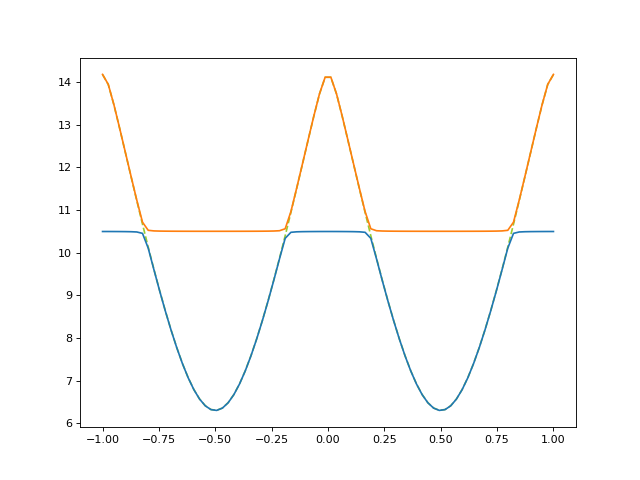

In [42]:
g = 0.1
omega_r = 10.5

e_high = []
e_low = []

for dE in (simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]):
    a = dE / 2
    b = omega_r / 2
    c = (dE - omega_r)/2
    
    factor = np.sqrt(c**2 + g**2)
    e_high.append(a+b+factor)
    e_low.append(a+b-factor)
    

# ax.plot(flux_list, np.array(e_high) - np.array(e_low))
fix, ax = plt.subplots(1, 1, figsize=(8,6))

# @interact
# def plotme(scale=(0,50,1), offset=(-10,0,0.1)):
    
ax.plot(FLUX_NUMBER, transition01,
        color=MY_COLOURS["Green"],
        label="Expected",
        linestyle='--'
        )
ax.plot(FLUX_NUMBER, e_low)
ax.plot(FLUX_NUMBER, e_high)
# ax.set_ylim([10, 11])

# Master equations simulation

We are solving the master equation for the full system


In [1]:
import qutip as qt

## Representation in 2 qubit - 3 resonator basis

We will use the truncated subspace of vectors in the following $\left|e, n\right\rangle, \left|e, n+1\right\rangle, \left|g, n\right\rangle, \left|g, n+1\right\rangle$.

The representation of operator $\hat{A}$ in this subspace will be
\begin{equation}
 \begin{pmatrix}
   \left\langle e, n\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n\right|\hat{A}{\left|g, n\right\rangle} & \left\langle e, n\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle e, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|g, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle g, n\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n\right|\hat{A}{\left|g, n\right\rangle} & \left\langle g, n\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle g, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|g, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|g, n+1\right\rangle}\\
 \end{pmatrix}
\end{equation}

In [33]:
NR = 2
OFFSET = 2 # As python cannot work with symbols, we will sub in manuall the N values we operate around

qubit_ket = qt.basis(2,0)
resonator_ket = qt.basis(NR, 0)
example_state = qt.tensor(
    [
        qt.ket2dm(qubit_ket), 
        qt.ket2dm(resonator_ket)
    ])
example_state

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

\begin{equation}
  a^{\dagger}a =
  \begin{pmatrix}
    n & . & . & . \\
    . & n+1 & . & . \\
    . & . & n & . \\
    . & . & . & n+1
  \end{pmatrix}
\end{equation}

In [34]:
op_n = qt.tensor(
    qt.identity(2),
    qt.num(NR, offset=OFFSET)
)
op_n

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 3. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 3.]]

\begin{equation}
  a\sigma_{+}=
  \begin{pmatrix}
    . & . & . & \sqrt{n+1} \\
    . & . & . & . \\
    . & . & . & . \\
    . & . & . & .
  \end{pmatrix}
\end{equation}


In [35]:
op_a_sigmaplus = qt.tensor(
    qt.sigmap(),
    qt.destroy(NR, offset=OFFSET)
)
op_a_sigmaplus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         1.73205081]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]

\begin{equation}
  a^{\dagger}\sigma_-=
  \begin{pmatrix}
    . & . & . & . \\
    . & . & . & . \\
    . & . & . & . \\
    \sqrt{n+1} & . & . & .
  \end{pmatrix}
\end{equation}

In [36]:
op_adagger_sigmaminus = qt.tensor(
    qt.sigmam(),
    qt.create(NR, offset=OFFSET)
)
op_adagger_sigmaminus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [1.73205081 0.         0.         0.        ]]

\begin{equation}
  \sigma_z =
  \begin{pmatrix}
    1 & . & . & . \\
    . & 1 & . & . \\
    . & . & -1 & .\\
    . & . & . & -1
  \end{pmatrix}
\end{equation}

In [37]:
op_sigmaz = qt.tensor(
    qt.sigmaz(),
    qt.identity(NR)
)
op_sigmaz

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]

\begin{equation}
  a=
  \begin{pmatrix}
    . & \sqrt{n+1} & . & . \\
    . & .& .& .\\
    . & . & . & \sqrt{n+1} \\
    . & . & . & .
  \end{pmatrix}
\end{equation}

In [38]:
op_a = qt.tensor(
    qt.identity(2),
    qt.destroy(NR, offset=OFFSET)
)
op_a

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.         1.73205081 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         1.73205081]
 [0.         0.         0.         0.        ]]

\begin{equation}
  a^{\dagger}=
  \begin{pmatrix}
    . & . & . & . \\
    \sqrt{n} & .& .& .\\
    . & . & . & . \\
    . & . & \sqrt{n} & .
  \end{pmatrix}
\end{equation}


In [32]:
op_adagger = qt.tensor(
    qt.identity(2),
    qt.create(NR, offset=OFFSET)
)
op_adagger

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         0.        ]
 [8.24621125 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         8.24621125 0.        ]]

\begin{equation}
  \sigma_{-} =
  \begin{pmatrix}
    . & . & . & . \\
    . & . & . & . \\
    1 & . & . & . \\
    . & 1 & . & .
  \end{pmatrix}
\end{equation}

In [27]:
op_sigmaminus = qt.tensor(
    qt.sigmam(),
    qt.identity(NR)
)
op_sigmaminus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]

\begin{equation}
  \sigma_{+} =
  \begin{pmatrix}
    . & . & 1 & . \\
    . & . & . & 1 \\
    . & . & . & . \\
    . & . & . & .
  \end{pmatrix}
\end{equation}

In [28]:
op_sigmaplus = qt.tensor(
    qt.sigmap(),
    qt.identity(NR)
)
op_sigmaplus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [29]:
DELTA_Q = 0
DELTA_R = 0

mega_equation = 1j * DELTA_Q / 2 

## Master equation written out

 \begin{equation}
  \begin{aligned}
    \dot{\rho} = -\frac{i}{\hbar}\left[ \mathcal{H}, \rho \right] + \mathcal{L}\left[ \rho \right] & = i\frac{\delta_{q}}{2}\left[ \sigma_z\rho - \rho\sigma_z \right] -i\delta_{r}\left[ {a}^{\dagger}a\rho - \rho{a}^{\dagger}a \right]\\
    & - ig{\left[ a\sigma_+\rho - \rho{a}\sigma_+ + {a}^{\dagger}\sigma_{-}\rho - \rho{a}^{\dagger}\sigma_{-} \right]}\\
    & - i{\frac{\Omega}{2}}\left[ a\rho - \rho{a} + {a}^{\dagger}\rho - \rho{a}^{\dagger} \right]\\
    & + \frac{\kappa}{2}\left[ 2a\rho{a}^{\dagger} - {a}^{\dagger}a\rho - \rho{a}^{\dagger}a \right]\\
    & + \frac{\Gamma_{1}}{2}\left[ 2\sigma_{-}\rho\sigma_{+} - \sigma_+\sigma_{-}\rho - \rho\sigma_+\sigma_{-} \right]\\
    & + \frac{\Gamma_{\phi}}{2}\left[ \sigma_z\rho\sigma_z - \rho \right]
  \end{aligned}
 \end{equation}

## Representation in 2 qubit - 3 resonator basis

Note, I will switch the tensor spaces around compared to previously, as I want to group multiple resonator states under one qubit state.

We will use the truncated subspace of vectors in the following $\left|e, 0\right\rangle, \left|e, 1\right\rangle, \left|e, 2\right\rangle, \left|g, 0\right\rangle, \left|g, 1\right\rangle, \left|g, 2\right\rangle, $.

In [39]:
NR = 3
OFFSET = 0 # As python cannot work with symbols, we will sub in manuall the N values we operate around

qubit_ket = qt.basis(2,0)
resonator_ket = qt.basis(NR, 0)
example_state = qt.tensor(
    [
        qt.ket2dm(qubit_ket), 
        qt.ket2dm(resonator_ket)
    ])
example_state

Quantum object: dims = [[2, 3], [2, 3]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

\begin{equation}
  {a}^{\dagger}a =
  \begin{pmatrix}
    0 & . & . & . & . & .\\
    . & 1 & . & . & . & .\\
    . & . & 2 & . & . & .\\
    . & . & . & 0 & . & .\\
    . & . & . & . & 1 & .\\
    . & . & . & . & . & 2\\    
  \end{pmatrix}
\end{equation}

In [40]:
op_n = qt.tensor(
    qt.identity(2),
    qt.num(NR, offset=OFFSET)
)
op_n

Quantum object: dims = [[2, 3], [2, 3]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 2.]]

\begin{equation}
  a\sigma_{+}=
  \begin{pmatrix}
    . & . & . & . & \sqrt{1} & .\\
    . & . & . & . & . & \sqrt{2}\\
    . & . & . & . & . & .\\
    . & . & . & . & . & .\\
    . & . & . & . & . & .\\
    . & . & . & . & . & .\\
  \end{pmatrix}
\end{equation}

In [41]:
op_a_sigmaplus = qt.tensor(
    qt.sigmap(),
    qt.destroy(NR, offset=OFFSET)
)
op_a_sigmaplus

Quantum object: dims = [[2, 3], [2, 3]], shape = (6, 6), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         1.41421356]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]

\begin{equation}
  a^{\dagger}\sigma_-=
  \begin{pmatrix}
    . & . & . & . & . & .\\
    . & . & . & . & . & .\\
    . & . & . & . & . & .\\
    . & . & . & . & . & .\\
    \sqrt{1} & . & . & . & . & .\\
    . & \sqrt{2} & . & . & . & .\\    
  \end{pmatrix}
\end{equation}


In [42]:
op_adagger_sigmaminus = qt.tensor(
    qt.sigmam(),
    qt.create(NR, offset=OFFSET)
)
op_adagger_sigmaminus

Quantum object: dims = [[2, 3], [2, 3]], shape = (6, 6), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]
 [0.         1.41421356 0.         0.         0.         0.        ]]

\begin{equation}
  \sigma_z =
  \begin{pmatrix}
    1 & . & . & . & . & .\\
    . & 1 & . & . & . & .\\
    . & . & 1 & . & . & .\\
    . & . & . & -1 & . & .\\
    . & . & . & . & -1 & .\\
    . & . & . & . & . & -1\\
  \end{pmatrix}
\end{equation}

In [43]:
op_sigmaz = qt.tensor(
    qt.sigmaz(),
    qt.identity(NR)
)
op_sigmaz

Quantum object: dims = [[2, 3], [2, 3]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.]]

\begin{equation}
  a=
  \begin{pmatrix}
    . & \sqrt{1} & . & . & . & .\\
    . & . & \sqrt{2} & . & . & .\\
    . & . & . & . & . & .\\
    . & . & . & . & \sqrt{1} & .\\
    . & . & . & . & . & \sqrt{2}\\
    . & . & . & . & . & .\\    
  \end{pmatrix}
\end{equation}


In [44]:
op_a = qt.tensor(
    qt.identity(2),
    qt.destroy(NR, offset=OFFSET)
)
op_a

Quantum object: dims = [[2, 3], [2, 3]], shape = (6, 6), type = oper, isherm = False
Qobj data =
[[0.         1.         0.         0.         0.         0.        ]
 [0.         0.         1.41421356 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         1.41421356]
 [0.         0.         0.         0.         0.         0.        ]]

\begin{equation}
  a^{\dagger}=
  \begin{pmatrix}
    . & . & . & . & . & .\\
    \sqrt{1} & . & . & . & . & .\\
    . & \sqrt{2} & . & . & . & .\\
    . & . & . & . & . & .\\
    . & . & . & \sqrt{1} & . & .\\
    . & . & . & . & \sqrt{2} & .\\
  \end{pmatrix}
\end{equation}


In [45]:
op_adagger = qt.tensor(
    qt.identity(2),
    qt.create(NR, offset=OFFSET)
)
op_adagger

Quantum object: dims = [[2, 3], [2, 3]], shape = (6, 6), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]
 [0.         1.41421356 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.41421356 0.        ]]

\begin{equation}
  \sigma_{-} =
  \begin{pmatrix}
    . & . & . & . & . & .\\
    . & . & . & . & . & .\\
    . & . & . & . & . & .\\
    1 & . & . & . & . & .\\
    . & 1 & . & . & . & .\\
    . & . & 1 & . & . & .\\    
  \end{pmatrix}
\end{equation}


In [46]:
op_sigmaminus = qt.tensor(
    qt.sigmam(),
    qt.identity(NR)
)
op_sigmaminus

Quantum object: dims = [[2, 3], [2, 3]], shape = (6, 6), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]

\begin{equation}
  \sigma_{+} =
  \begin{pmatrix}
    . & . & . & 1 & . & .\\
    . & . & . & . & 1 & .\\
    . & . & . & . & . & 1\\
    . & . & . & . & . & .\\
    . & . & . & . & . & .\\
    . & . & . & . & . & .\\    
  \end{pmatrix}
\end{equation}


In [47]:
op_sigmaplus = qt.tensor(
    qt.sigmap(),
    qt.identity(NR)
)
op_sigmaplus

Quantum object: dims = [[2, 3], [2, 3]], shape = (6, 6), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]